<a href="https://colab.research.google.com/github/yous92/ML-Workshop/blob/main/Image_Segmentation_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch  #to take the pretrained model of unet
!pip install -U git+https://github.com/albumentations-team/albumentations #this library is for data augmentation
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  U

# About Dataset

### Dataset

the dataset used is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset


https://www.cs.toronto.edu/~vmnih/data/


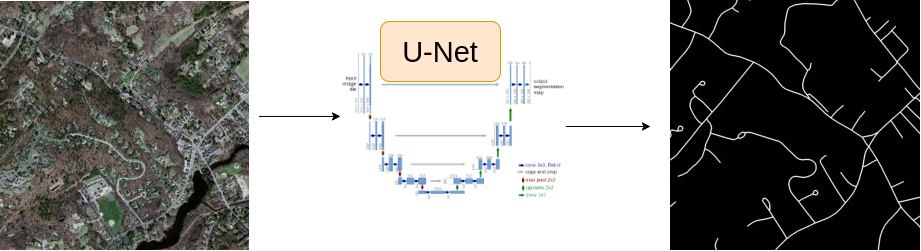

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411 (from 1)
Receiving objects: 100% (411/411), 851.74 MiB | 22.58 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


train.csv contains images paths and masks paths , it is usefull to read the images from both folders

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# 2. Setup Configurations

In [5]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR= '/content/Road_seg_dataset/'

DEVICE = 'cpu'

EPOCHS = 5
LR= 0.003
BATCH_SIZE = 4
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
#the encoder used in unet architecture
WEIGHTS = 'imagenet' #the weights to initialize with



In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [7]:
idx = 2
row = df.iloc[idx]
image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) #cv2 read images in BGR format we need to convert it to RGB
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255


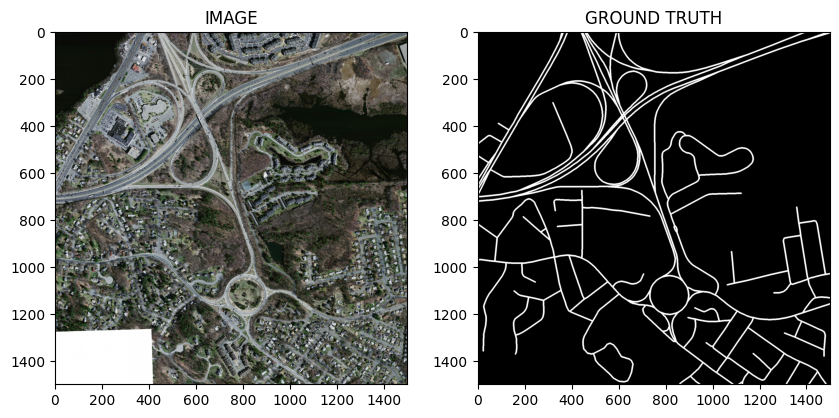

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state=42)

In [10]:

len(train_df)

159

# 3. Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as A

In [12]:
def get_train_augs(): #contains the series of augmentations
 return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p=0.5), #50% chance the image get fliped
      A.VerticalFlip(p=0.5)
  ])

#no augmentation foa valid only resize
def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ])

# 4. Create Custom Dataset

In [13]:
from torch.utils.data import Dataset


In [14]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std =  [0.229, 0.224, 0.225]

In [15]:
import torchvision.transforms as transforms

In [16]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations): #initialize the augmentation and the dataframe

      self.df = df
      self.augmentations = augmentations

  def __len__(self):  #return the size of the dataset
    return len(self.df)

  def __getitem__(self, indx): #returns one item image and mask
      row = self.df.iloc[idx]
      image_path = DATA_DIR + row.images
      mask_path = DATA_DIR + row.masks

      image = cv2.imread(image_path)
      image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) #cv2 read images in BGR format we need to convert it to RGB
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w)
      mask = np.expand_dims(mask, axis = -1) #add at last (h,w,c)
      normalize = transforms.Normalize(mean= imagenet_mean, std=imagenet_std)
      if self.augmentations:
          data = self.augmentations(image=image, mask=mask) #albumintation reurns a dictionary
          image = data['image']
          mask = data['mask']

          #(h,w,c) -> (c,h,w) because pytorch use (c,h,w)

      image = np.transpose(image,(2,0,1)).astype(np.float32) #(c,h,w)
      mask = np.transpose(mask,(2,0,1)).astype(np.float32)#(c,h,w)

      image = torch.Tensor(image)/255.0
      # image = normalize(image)
      # image = (img - img.min()) / (img.max() - img.min())
      mask = torch.round(torch.Tensor(mask) / 255.0)



      return image, mask


In [18]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

[0.2167, 0.1250, 0.1583,  ..., 0.3625, 0.4167, 0.5208],
         [0.3500, 0.2125, 0.1167,  ..., 0.4708, 0.4792, 0.5042],
         [0.3208, 0.2667, 0.1833,  ..., 0.5208, 0.5208, 0.6542],
         ...,
         [0.6125, 0.6000, 0.5917,  ..., 0.1458, 0.2875, 0.2750],
         [0.6042, 0.6167, 0.5792,  ..., 0.2208, 0.1333, 0.1417],
         [0.6708, 0.6292, 0.6167,  ..., 0.1708, 0.4250, 0.1875]],

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch


def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

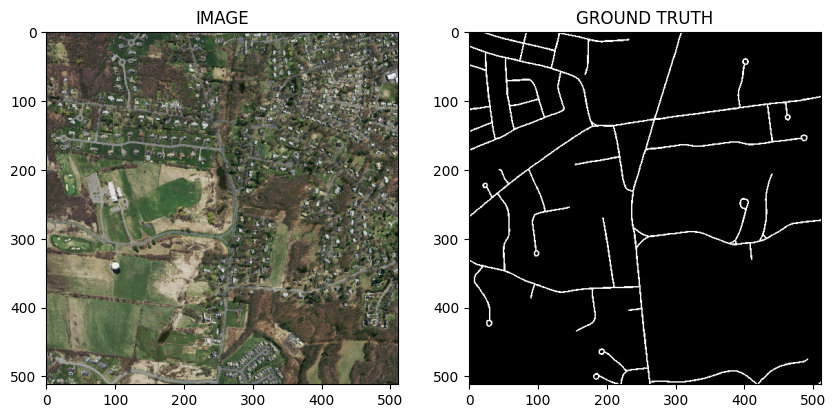

In [23]:
show_image(image, mask)

In [24]:
img, mask = trainset[0]
print(img)
print("mask is")
print(mask)

tensor([[[0.2275, 0.1412, 0.1725,  ..., 0.3647, 0.4157, 0.5137],
         [0.3529, 0.2235, 0.1333,  ..., 0.4667, 0.4745, 0.4980],
         [0.3255, 0.2745, 0.1961,  ..., 0.5137, 0.5137, 0.6392],
         ...,
         [0.6000, 0.5882, 0.5804,  ..., 0.1608, 0.2941, 0.2824],
         [0.5922, 0.6039, 0.5686,  ..., 0.2314, 0.1490, 0.1569],
         [0.6549, 0.6157, 0.6039,  ..., 0.1843, 0.4235, 0.2000]],

        [[0.2157, 0.1529, 0.1843,  ..., 0.3176, 0.4000, 0.5608],
         [0.2824, 0.2078, 0.1529,  ..., 0.4980, 0.5373, 0.4902],
         [0.2627, 0.2549, 0.2000,  ..., 0.5412, 0.5333, 0.6667],
         ...,
         [0.6157, 0.5922, 0.5804,  ..., 0.1843, 0.2824, 0.2549],
         [0.6000, 0.6157, 0.5725,  ..., 0.2431, 0.1765, 0.1686],
         [0.6588, 0.6196, 0.6118,  ..., 0.1922, 0.3725, 0.2000]],

        [[0.1725, 0.1451, 0.1647,  ..., 0.3176, 0.4118, 0.3490],
         [0.2510, 0.1843, 0.1412,  ..., 0.5137, 0.5608, 0.3922],
         [0.2314, 0.2078, 0.1765,  ..., 0.5765, 0.5686, 0.

In [25]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 159
Size of Validset : 40


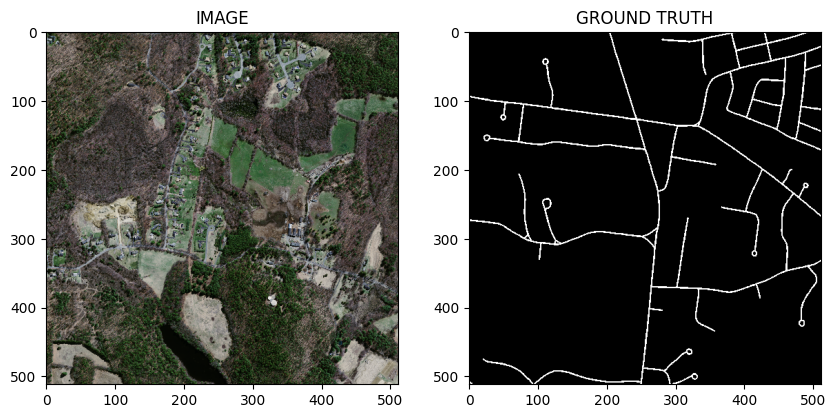

In [27]:
idx = 3
image, masks =  trainset[idx]
helper.show_image(image,mask)

# 5. Load dataset into batches

In [28]:
from torch.utils.data import DataLoader

In [29]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [30]:
print(f'total no. of batches in trainloader : {len(trainloader)}')
print(f'total no. of batches in validloader : {len(validloader)}')

total no. of batches in trainloader : 40
total no. of batches in validloader : 10




# 6. Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [32]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss #segmentation loss




In [33]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(

        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1, #binary classification probelem
        activation = None #this is the last activation function(layer) , output will be logits without any segmoid or softmax activation function
    )

  def forward(self, images, masks = None):

      logits = self.backbone(images)
      if masks != None:  #true when doing testing or inference at that time the mask will be none

          return logits, DiceLoss(mode='binary')(logits,masks) + nn.BCEWithLogitsLoss()(logits, masks)
      return logits #only return the predictions when inference


In [34]:
model = SegmentationModel()
model.to('cpu');
model
# the weights are getting download


Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 31.1MB/s]


SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

# 7. Create Train and Validation Function

In [35]:
def train_fn(data_loader, model, optimizer):
  model.train() #specify the model as trian so he can know to use the dropout and batch normalization layers, turn ON dropout, batchnorm, tec.. they are necessaruy during training
  total_loss = 0.0

  for images, masks in tqdm(data_loader): #tqdm to track the number of batches

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)


    optimizer.zero_grad()
    logits, loss = model(images,masks)
    loss.backward() #find the gradients
    optimizer.step() #update the weights and bias(params of the model)

    total_loss += loss.item()

  return total_loss / len(data_loader) #return the average loss

In [36]:
def eval_fn(data_loader, model):
  model.eval() #model.eval() because dont want to use any dropout layer
  total_loss = 0.0

  for images, masks in tqdm(data_loader): #tqdm to track the number of batches
#this should not contain any gradient computation
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    logits, loss = model(images,masks)

    total_loss += loss.item()

  return total_loss / len(data_loader)

# 8. Train Model

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

In [38]:
best_valid_loss = np.inf
epochs = 5
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  # if valid_loss < best_valid_loss:
  #   torch.save(model.state_dict(), 'best_model.pt')
  #   print('SAVED_MODEL')
  #   best_valid_loss = valid_loss


  print(f'Epch: {i+1} Train_loss : {train_loss} valid_loss : {valid_loss}')
torch.save(model.state_dict(), 'best_model.pt')
print('SAVED_MODEL')

100%|██████████| 10/10 [00:44<00:00,  4.42s/it]


Epch: 1 Train_loss : 0.6002049259841442 valid_loss : 2.0120933055877686


100%|██████████| 10/10 [00:44<00:00,  4.45s/it]


Epch: 2 Train_loss : 0.11199256721884013 valid_loss : 2.2046782970428467


100%|██████████| 10/10 [00:41<00:00,  4.18s/it]


Epch: 3 Train_loss : 0.05552250938490033 valid_loss : 2.3047099113464355


100%|██████████| 10/10 [00:43<00:00,  4.38s/it]


Epch: 4 Train_loss : 0.046420594304800035 valid_loss : 2.4603285789489746


100%|██████████| 10/10 [00:43<00:00,  4.32s/it]


Epch: 5 Train_loss : 0.03194043980911374 valid_loss : 2.5316977500915527
SAVED_MODEL


# 9. Inference

In [ ]:
idx = 3

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #unsqueeze at the axis 0 to add the batch dimension , the image tensor has the shape (c,h,w) -> (1,c,h,w), logits without any softmax or activation function

pred_mask = torch.sigmoid(logits_mask) #apply segmoid activation as this is binary segmentation problem
pred_mask = (pred_mask > 0.5)*1.0


# the dataset was too small so we have split in into valid set and train set there is no test set
#we gonna use valid set as test set




NameError: ignored

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))